# Edge coupler

In [1]:
# Import necessary packages
import gplugins.modes as gmode
import numpy as np
import matplotlib.pyplot as plt

import gdsfactory as gf
import meep as mp
# import gplugins.gmeep as gm
import gdsfactory.cross_section as xs

import gplugins.gmeep as gmeep
import pandas as pd

Using MPI version 4.1, 1 processes
2025-10-27 19:42:38.469 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']


Mode overlapping method

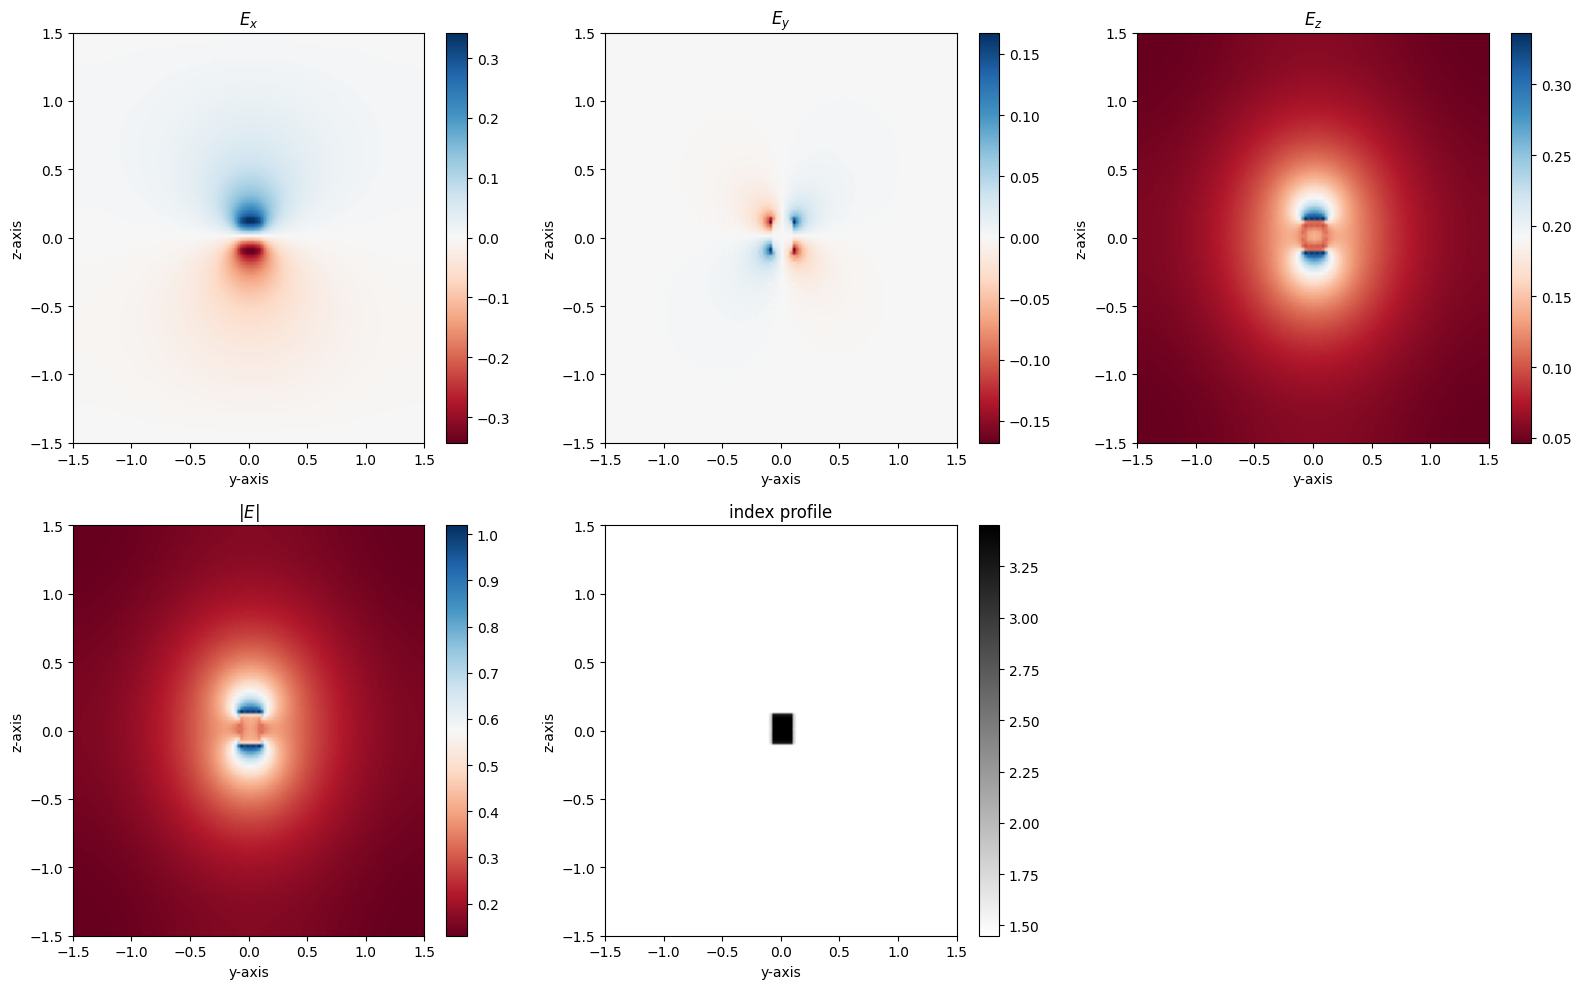

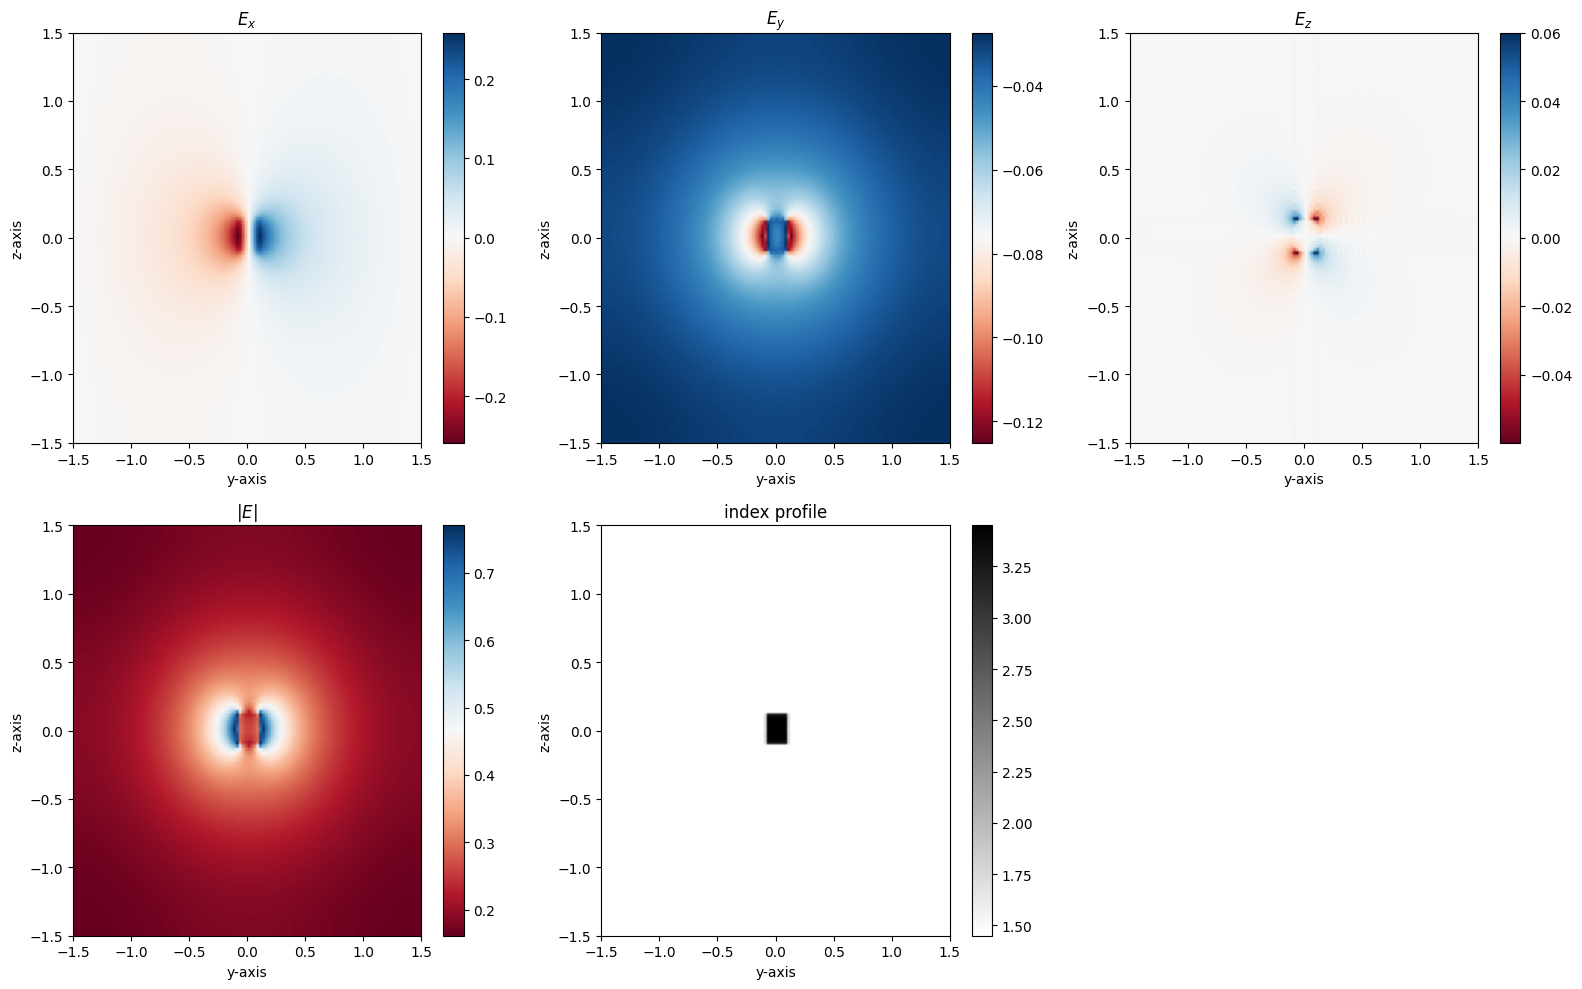

Effective index of mode 1 =  1.488715595441966
Effective index of mode 2 =  1.4710532916621737
The group index = 1.829190062206731


In [2]:
# Calcualte neff and group index using mode solver from gplugins
modes = gmode.find_modes_waveguide(
    parity=mp.NO_PARITY,
    core_width=0.180,
    core_material=3.45,
    clad_material=1.45,
    core_thickness=0.22,
    resolution=40,
    sy=3,
    sz=3,
    nmodes=4,
)
m1 = modes[1]
m2 = modes[2]
m3 = modes[3]

m1.plot_e_all()
m2.plot_e_all()

print("Effective index of mode 1 = ", m1.neff)
print("Effective index of mode 2 = ", m2.neff)

# Calcualting the group index
disp = gmode.find_mode_dispersion(
    wavelength=1.55,
    wavelength_step = 0.01,
    core='Si',
    clad='SiO2',
    mode_number=1, 
    core_thickness=0.22,
    core_width=0.180
            )
print('The group index =', disp.ng)

TODO: Calculate the mode overlap of the gaussian mode and the taper mode

## Adiabatic taper from gdsfactory

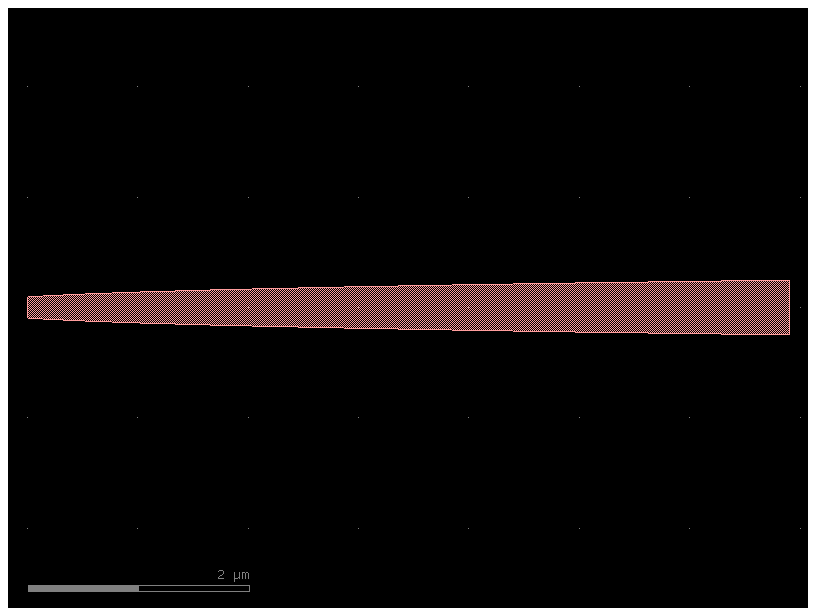

In [3]:
taper = gf.components.taper_adiabatic(width1=0.19, width2=0.5, length=0, alpha=0.02)
# taper.draw_ports()
taper.plot()
scene = taper.to_3d()
scene.show()

Using 3D MEEP for the edgecoupler

In [31]:
%%writefile ec_MPI_sim.py
import gplugins.modes as gmode
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory as gf
import gplugins.gmeep as gm
import gdsfactory.cross_section as xs
import sys

mp.verbosity(3)
sys.stdout.flush()
# Set up frequency points for simulation
npoints = 50
lcen = 1.55
dlam = 0.100
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl

# Center frequency mode_parity
mode_parity = mp.ODD_Y #mp.EVEN_Y + mp.ODD_Z
dpml = 2
dpad = 1
resolution = 30

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

abd_taper = gf.components.taper_adiabatic(width1=0.19, width2=0.5, length=0, alpha=0.02)

sub_t = 2
sio_t = 2
si_t = 0.220
air_t = 1
cladding_t = 1
sx = abd_taper.xsize + 2*dpml + 2
sy = abd_taper.ysize + 2*dpml + 2 * dpad
sz = 2*(sub_t+sio_t+si_t+dpml+air_t)

# Cell size
cell_size = mp.Vector3(sx,sy,sz)

# Create the ring resonator component
# abd_taper = gf.components.extend_ports(abd_taper, port_names=["o2"], length=1)
abd_taper = abd_taper.copy()

abd_taper.flatten()
abd_taper.center = (0, 0)

# Get geometry from component
coupler_geo = gm.get_meep_geometry.get_meep_geometry_from_component(abd_taper, is_3d=True)

geometry = []

# SiO2 cladding
geometry.append(
   mp.Block(
    center=mp.Vector3(0, 0, si_t/2),
    size=(mp.inf, mp.inf, cladding_t),
    material=SiO2
  )  
)

# GC geometry
geometry += [
    mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
    for geom in coupler_geo
]

# geometry.append(geom_coupler)

# SiO2 slab 
geometry.append(
  mp.Block(center=mp.Vector3(0, 0, -sio_t/2), size=(mp.inf, mp.inf, sio_t), material=SiO2)  
)

# Si substrate 
geometry.append(
  mp.Block(center=mp.Vector3(0, 0, -sio_t-sub_t/2), size=(mp.inf, mp.inf, sub_t), material=Si)  
)

spot_size= 2.5
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [mp.GaussianBeam3DSource(
  src=src,
  size=mp.Vector3(0,0.5,2*si_t),
  center=mp.Vector3(abd_taper.ports["o1"].x, abd_taper.ports["o1"].y, si_t/2),
  beam_kdir = mp.Vector3(1,0,0),
  beam_E0=mp.Vector3(0,1,0),
  beam_w0=spot_size/2,
)]
sim = mp.Simulation(
  resolution=resolution,
  cell_size=cell_size,
  boundary_layers=[mp.Absorber(dpml)],
  sources=source,
  geometry=geometry,
  dimensions=3
)

taper_monitor_port = mp.ModeRegion(
  size=mp.Vector3(0,1,si_t+sio_t),
  center=mp.Vector3(abd_taper.ports["o2"].x, abd_taper.ports["o2"].y, 0),
)
taper_monitor = sim.add_mode_monitor(fpoints,taper_monitor_port)
taper_monitor_port_2 = mp.ModeRegion(
  size=mp.Vector3(0,1,si_t+sio_t),
  center=mp.Vector3(abd_taper.ports["o1"].x, abd_taper.ports["o1"].y, 0),
)
taper_monitor_2 = sim.add_mode_monitor(fpoints,taper_monitor_port_2)

dft_xz = sim.add_dft_fields([mp.Ey], fcen, 0,1,center=mp.Vector3(0,0,0), size=mp.Vector3(abd_taper.xsize,0,sz))

dft_xy = sim.add_dft_fields([mp.Ey], fcen, 0,1,center=mp.Vector3(0,0,0.160), size=mp.Vector3(abd_taper.xsize, abd_taper.ysize+2,0))

dft_yz_1 = sim.add_dft_fields([mp.Ey], fcen, 0,1, center=mp.Vector3(abd_taper.ports["o1"].x,abd_taper.ports["o1"].y,0), size=mp.Vector3(0, abd_taper.ysize+2, sz/4))

dft_yz_2 = sim.add_dft_fields([mp.Ey], fcen, 0,1, center=mp.Vector3(abd_taper.ports["o2"].x,abd_taper.ports["o2"].y,0), size=mp.Vector3(0, abd_taper.ysize+2, sz/4))
vol1 = mp.Volume(
    center=mp.Vector3(0, 0, 0),
    size=mp.Vector3(sx, 0,sz)
    )
vol2 = mp.Volume(
    center=mp.Vector3(0, 0, 0.160),
    size=mp.Vector3(sx, sy,0),
    )
vol3 = mp.Volume(
  center=mp.Vector3(abd_taper.ports["o1"].x,abd_taper.ports["o1"].y,0), 
  size=mp.Vector3(0, abd_taper.ysize+2, sz/4)
)
if mp.am_master():
  eps_parameters = dict(contour=False)
  sim.plot2D(output_plane=vol1, eps_parameters=eps_parameters,labels=True)
  plt.savefig('edge_coupler_sim.png', dpi=150, bbox_inches='tight')
  plt.close()
  eps_parameters = dict(contour=False)
  sim.plot2D(output_plane=vol2, eps_parameters=eps_parameters,labels=True)
  plt.savefig('edge_coupler_sim_2.png', dpi=150, bbox_inches='tight')
  plt.close()
  eps_parameters = dict(contour=False)
  sim.plot2D(output_plane=vol3, eps_parameters=eps_parameters,labels=True)
  plt.savefig('edge_coupler_sim_3.png', dpi=150, bbox_inches='tight')
  plt.close()

def progress(sim):
    if mp.am_master():
        print(f"t = {sim.meep_time():.1f}")
        sys.stdout.flush()

sim.run(mp.at_every(10, progress),
 until_after_sources=mp.stop_when_energy_decayed(dt=50, decay_by=1e-4))

port1_coeff = (
  sim.get_eigenmode_coefficients(taper_monitor, 
  [1], eig_parity=mp.ODD_Y)
)
port2_coeff = (
  sim.get_eigenmode_coefficients(taper_monitor_2, 
  [1], eig_parity=mp.ODD_Y)
)
norm = port2_coeff.alpha[:,:,0].flatten()
s21 = port1_coeff.alpha[:,:,0].flatten()
ez_data_1=sim.get_dft_array(dft_xy,mp.Ey,0)
ez_data_2=sim.get_dft_array(dft_xz,mp.Ey,0)
ez_data_3=sim.get_dft_array(dft_yz_1,mp.Ey,0)
ez_data_4=sim.get_dft_array(dft_yz_2,mp.Ey,0)

if mp.am_master():
  np.save('ec_wavelengths.npy', wl)
  np.save('ec_s21.npy', s21)
  np.save('ec_norm.npy', norm)
  np.save('ec_ez_data_1.npy', ez_data_1)
  np.save('ec_ez_data_2.npy', ez_data_2)
  np.save('ec_ez_data_3.npy', ez_data_3)
  np.save('ec_ez_data_4.npy', ez_data_4)
  
  # Create field plot
  fig = plt.figure(figsize=(12, 8))
  ax_field = fig.add_subplot(1, 1, 1)
  ax_field.set_title("Steady State Fields")
  # ax_field.imshow(
  #     np.flipud(np.transpose(eps_data)),
  #     interpolation="spline36",
  #     cmap="binary"
  # )

  ax_field.imshow(
      np.flipud(np.transpose(np.real(ez_data_1))),
      interpolation="spline36",
      cmap="RdBu",
      alpha=0.9,
  )
  ax_field.axis("off")
  plt.savefig('fgc_steady_state_fields.png', dpi=150, bbox_inches='tight')
  plt.close()
  fig = plt.figure(figsize=(12, 8))
  ax_field = fig.add_subplot(1, 1, 1)
  ax_field.set_title("Steady State Fields")
  # ax_field.imshow(
  #     np.flipud(np.transpose(eps_data)),
  #     interpolation="spline36",
  #     cmap="binary"
  # )

  ax_field.imshow(
      np.flipud(np.transpose(np.real(ez_data_2))),
      interpolation="spline36",
      cmap="RdBu",
      alpha=0.9,
  )
  ax_field.axis("off")
  plt.savefig('fgc_steady_state_fields_2.png', dpi=150, bbox_inches='tight')
  plt.close()
  print("Simulation completed successfully!")
  print(f"Results saved to: wavelengths.npy, port1_coeff.npy, port2_coeff.npy, eps_data.npy, ez_data.npy")
  print(f"Plots saved to: simulation_geometry.png, steady_state_fields.png")



Overwriting ec_MPI_sim.py


In [ ]:
!mpirun -np 34 python ec_MPI_sim.py

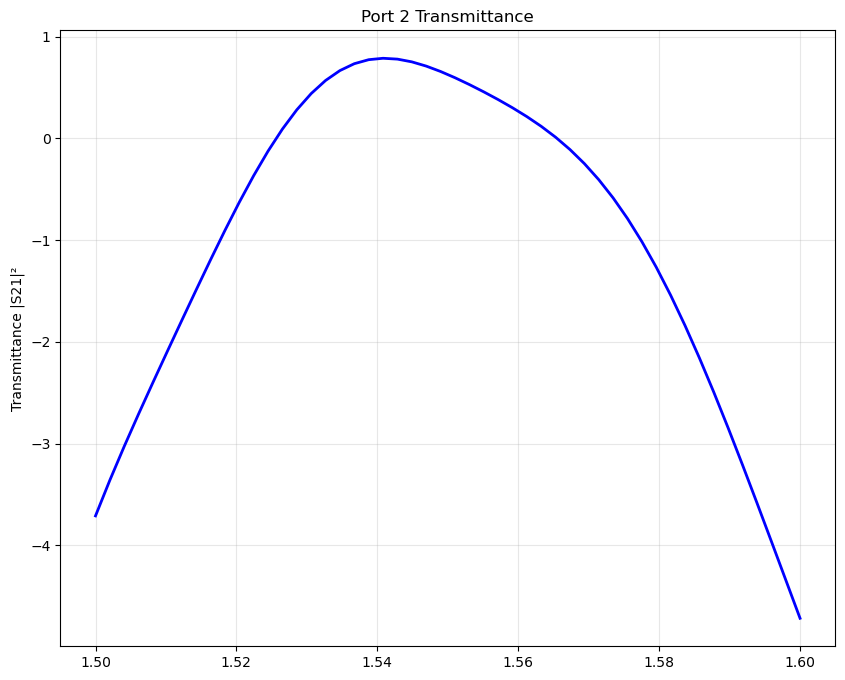

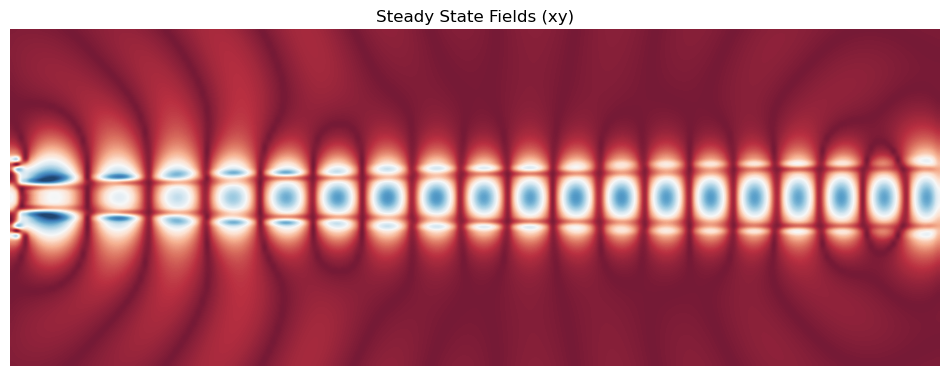

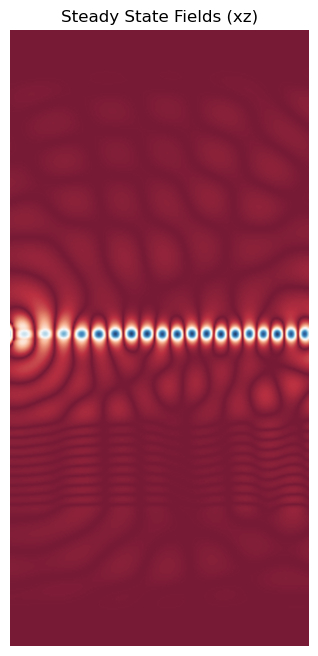

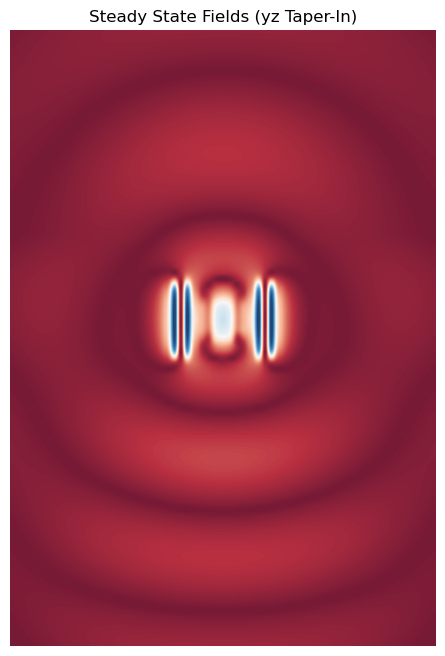

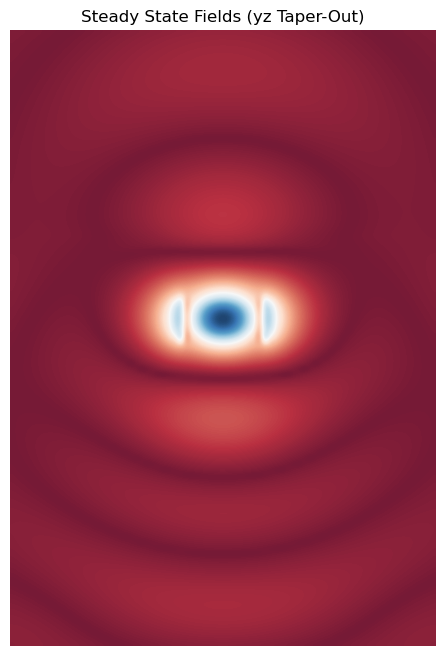

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Load results
wl = np.load('ec_wavelengths.npy')
port1_coeff = np.load('ec_s21.npy')
# port2_coeff = np.load('fgc_s12.npy')
ez_data_1 = np.load('ec_ez_data_1.npy')
ez_data_2 = np.load('ec_ez_data_2.npy')
ez_data_3 = np.load('ec_ez_data_3.npy')
ez_data_4 = np.load('ec_ez_data_4.npy')

# Plot transmission spectrum
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8))

# S11 (reflection)
ax1.plot(wl, 10*np.log10(np.abs(port1_coeff)**2), 'b-', linewidth=2)
ax1.set_ylabel('Transmittance |S21|²')
ax1.set_title('Port 2 Transmittance')
ax1.grid(True, alpha=0.3)


fig = plt.figure(figsize=(12, 8))
ax_field = fig.add_subplot(1, 1, 1)
ax_field.set_title("Steady State Fields (xy)")
ax_field.imshow(
    np.flipud(np.transpose(np.abs(np.real(ez_data_1)))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()
fig = plt.figure(figsize=(12, 8))
ax_field = fig.add_subplot(1, 1, 1)
ax_field.set_title("Steady State Fields (xz)")
ax_field.imshow(
    np.flipud(np.transpose(np.abs(np.real(ez_data_2)))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()
fig = plt.figure(figsize=(12, 8))
ax_field = fig.add_subplot(1, 1, 1)
ax_field.set_title("Steady State Fields (yz Taper-In)")
ax_field.imshow(
    np.flipud(np.transpose(np.abs(np.real(ez_data_3)))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()
fig = plt.figure(figsize=(12, 8))
ax_field = fig.add_subplot(1, 1, 1)
ax_field.set_title("Steady State Fields (yz Taper-Out)")
ax_field.imshow(
    np.flipud(np.transpose(np.abs(np.real(ez_data_4)))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()